In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
import gc

%matplotlib inline

### Preparando o ambiente

In [2]:
# identificar se a execução é S.O. Windows(PC) ou não (nuvem)

import os
import platform

#diretorio corrente
diretorio_corrente = os.getcwd()
# print(f'O diretório corrente é \n{diretorio_corrente}')

# S.O
sis_op = platform.system()
# print(f'O Sistema Operacional é {sis_op}')


In [3]:
#configurando diretorio
# Se windows:
print(sis_op)

# print('Sistema Operacional:' , sis_op)

if sis_op == 'Windows':
    diretorio = os.path.join(os.path.dirname(diretorio_corrente), 'dados', 'News')
    # diretorio = diretorio_corrente + '\BDs\BD Fakenews\Fake an Real News'

else: # Se colab
    diretorio = os.path.join(diretorio_corrente,'drive','Othercomputers','Meu computador','MBA','TCC','dados','News')
    from google.colab import drive
    drive.mount('/content/drive')

# os.listdir(diretorio)

Windows


In [4]:
print(diretorio)

C:\Users\T-Gamer\Documents\Cursos\MBA\TCC\dados\News


### trabalhando Dataset

##### Carregando Dataset #1 - df

In [18]:
# Carregando o dataset #1
#df= pd.read_excel(diretorio + '/desinfopedia_final.csv')
dff = pd.read_csv(diretorio + '/Fake.csv')
dft = pd.read_csv(diretorio + '/True.csv')


dft['target']=1
dff['target']=0

#concatenando os datasets
df_1 = pd.concat([dft,dff])

# separando textos e classes
#obtendo textos
texts_df1 = df_1['text'].astype(str)

# obtendo categorias
y_df1_names = df_1['subject'].unique()

# convertendo subject em target
label_encoder = LabelEncoder()
df_1['target'] = label_encoder.fit_transform(df_1['subject'])



# fazendo copia do dataset
data_1=df_1



In [19]:
# obtendo rótulos individuais
y_df1_all_names = df_1['subject']
y_df1 = df_1['target']

In [20]:
# Exibindo os rótulos convertidos
df1_labels, df1_sizes = np.unique(y_df1, return_counts=True)
true_k_f1 = df1_labels.shape[0]
print(f"{df_1.shape[0]} documents - {true_k_f1} categories")

44898 documents - 8 categories


### Visualização dos dados brutos


In [21]:
# comentado para poupar RAM do ambiente google
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Agregando todos os textos
textos_df1 = " ".join(texto for texto in df_1['text'])



In [22]:
# Criando a nuvem de palavras
# wordcloud_df = WordCloud(background_color='white').generate(textos_df1)
wordcloud_df = WordCloud(width=800, height=400, max_font_size=100, max_words=100, min_font_size=10,background_color='white').generate(textos_df1)


Visualização dos dados brutos


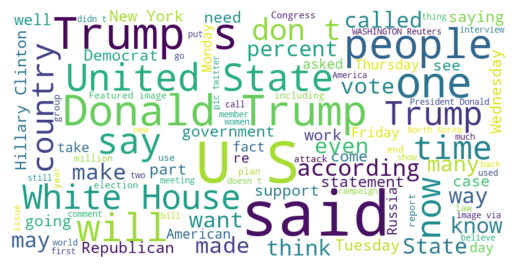

In [23]:
# Visualizando a nuvem de palavras
print('Visualização dos dados brutos')
plt.imshow(wordcloud_df, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
from PIL import Image
import io
import win32clipboard
# Converter a nuvem de palavras para um objeto Image
image = wordcloud_df.to_image()

# Salvar a imagem em um objeto bytes
img_byte_arr = io.BytesIO()
image.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()


In [25]:
wordcloud_df.to_file("df1_brutos.png")
print(f'arquivo df1_brutos.png criado')

In [26]:
df_1.head()


,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",6
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",6
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",6
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",6
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",6


### Pré-Processamento

Serão realizados os seguintes processamentos:
 processo de lemmatização:


1.   remoção de caracteres não alfa e conversão para minúsculas
2.   remoção de palavras isoladas e espaços extras, remoção de números;
3.  remoção de stowords
4. Lemtização
5. undersumpling

#### Undersampling

In [27]:
# #undersambpling do df - tipo 1: retirada do conjunto de maior volume
# # redução a 20% dos 5 assuntos de maior frequencia

# excluir=['politicsNews','worldnews','News','politics','left-news']
# dfu = data_1.query('subject not in @excluir')

# # redução a 20% dos 5 assuntos de maior frequencia
# for i in excluir:
#     sub_set = df_1[df_1['subject']== i]
#     n = np.int64(sub_set.shape[0]/5)
#     dfu = pd.concat([dfu,sub_set.sample(n)], axis=0)
#     dfu.shape




In [28]:
#undersambpling do df - tipo 2: retirada dos conjuntos menores

excluir=['Government News','US_News','Middle-east']
dfu = data_1.query('subject not in @excluir')

# # redução a 20% dos 5 assuntos de maior frequencia
# for i in excluir:
#     sub_set = df_1[df_1['subject']== i]
#     n = np.int64(sub_set.shape[0]/5)
#     dfu = pd.concat([dfu,sub_set.sample(n)], axis=0)
#     dfu.shape

dfu['subject'].unique()


array(['politicsNews', 'worldnews', 'News', 'politics', 'left-news'],
      dtype=object)

In [29]:
print('proporções originais: \n assunto            % \n----------------------------- ')
print(np.round(df_1['subject'].value_counts()/df_1.shape[0]*100,2))
print(f'total: {df_1.shape[0]}')

print('\n----------------------------- \n proporções ajustadas: \n assunto            % \n-----------------------------')
print(np.round(dfu['subject'].value_counts()/dfu.shape[0]*100,2))
print(f'total: {dfu.shape[0]}')

df_1 = dfu

proporções originais: 
 assunto            % 
----------------------------- 
politicsNews       25.11
worldnews          22.60
News               20.16
politics           15.24
left-news           9.93
Government News     3.50
US_News             1.74
Middle-east         1.73
Name: subject, dtype: float64
total: 44898

----------------------------- 
 proporções ajustadas: 
 assunto            % 
-----------------------------
politicsNews    26.99
worldnews       24.29
News            21.67
politics        16.38
left-news       10.68
Name: subject, dtype: float64
total: 41767


In [30]:
#tanserido para o notebook de tratamento K-means, não funcionou na exeução indireta.
# #limpando valores repetidos no início, 

# import regex as re
# # df_1['text'] = df_1['text'].str.replace(r'^.*\(Reuters\) - ', '', regex=True)
# df_1.loc[:, 'text'] = df_1['text'].str.replace(r'^.*\(Reuters\) - ', '', regex=True)
# # df_1['text'] = df_1['text'].str.replace(r'@realDonaldTrump\s*:\s*-\s*', '', regex=True, flags=re.IGNORECASE)
# df_1.loc[:, 'text'] = df_1['text'].str.replace(r'@realDonaldTrump\s*:\s*-\s*', '', regex=True, flags=re.IGNORECASE)

# # limpando ocorrências vazias:
# df_1 = df_1[~(df_1['text'].str.strip() == '')]


In [31]:
# Suponha que df_1 seja seu DataFrame e você esteja recebendo o aviso ao tentar modificar a coluna 'text'
# Use .loc para evitar o aviso e modificar a coluna 'text' diretamente



In [32]:
df_1 = df_1.drop(['title','date'], axis=1)
print('============')